<a href="https://colab.research.google.com/github/AnkeHooliganke/ml-course/blob/main/ananan/mnist_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Распознавание рукописных цифр из датасета MNIST с помощью сверточной нейросети.

Выполнила студент 431 группы Алтынова Анна.

Цель: построить классификатор для рукописных цифр на основе нейросети.

Проделано преимущественно на основе библиотеки Pytorch.

шаг 0: загрузка датасета(тренировка и тест), вывод примеров изображений

шаг 1: препроцессинг данных: разбиение на батчи по 1024 элемента(генератор), нормировка по первому батчу.

шаг 2: построение первой сети, 

  архитектура: свертка - активация - свертка - активация -пулинг - флаттен - активация - линейный слой -активация- линейный слой - софтмакс 

  в качестве функции активации использована relu,
  сдвиг в свертках = 3, паддинг 0, кол-во каналов 1->16, 16->64 соответственно,
  количество параметров 9216

шаг 3: тренировка: 5 эпох, оптимизатор Adam, learning rate = 0.001, потери -  относительная кросс-энтропия

  результат: потери 0.023

  распределение accuracy по цифрам: 

  0 accuracy: 0.9959183673469387

  1 accuracy: 0.9964757709251101

  2 accuracy: 0.9893410852713178

  3 accuracy: 0.9871287128712871

  4 accuracy: 0.9989816700610998

  5 accuracy: 0.9854260089686099

  6 accuracy: 0.9874739039665971

  7 accuracy: 0.9785992217898832

  8 accuracy: 0.9774127310061602
  
  9 accuracy: 0.958374628344896

шаг 4: подсчет accuracy в среднем и для каждого класса, вывод примера предсказаний

  результат: средняя accuracy 0.9855

шаг 5: построение второй сети на основе первой, добавлены batchnorm и dropout слои

шаг 6: тренировка (аналогично 3),

  результат: потери 0.019

  распредение accuracy по цифрам:

     0 accuracy: 0.9979591836734694
      1 accuracy: 0.9955947136563876
      2 accuracy: 0.9903100775193798
      3 accuracy: 0.9930693069306931
      4 accuracy: 0.9928716904276986
      5 accuracy: 0.992152466367713
      6 accuracy: 0.9874739039665971
      7 accuracy: 0.9863813229571985
      8 accuracy: 0.9876796714579056
      9 accuracy: 0.9821605550049554

шаг 7: аналогично 4

  результат: средняя accuracy 0.9907

 шаг 8: загрузка собственных цифр(10шт), приведение к детасетному виду,  нормировка, оценка моделью, вывод изображений с оценкой

 результат: распознано 9/10

In [ ]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor, Normalize, Compose

import warnings
warnings.filterwarnings("ignore")



In [ ]:
dataset_train = torchvision.datasets.MNIST(root='/content/drive/MyDrive', download=False, transform=ToTensor())
dataset_test = torchvision.datasets.MNIST(root='/content/drive/MyDrive', train=False, download=False, transform=ToTensor())

In [ ]:
dataset_test, dataset_train

(Dataset MNIST
     Number of datapoints: 10000
     Root location: /content/drive/MyDrive
     Split: Test
     StandardTransform
 Transform: ToTensor(), Dataset MNIST
     Number of datapoints: 60000
     Root location: /content/drive/MyDrive
     Split: Train
     StandardTransform
 Transform: ToTensor())

In [ ]:
X_train, X_test, y_train, y_test = dataset_train.data, dataset_test.data, dataset_train.targets, dataset_test.targets

In [ ]:
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
num_test = X_test.shape[0]

Training data shape:  torch.Size([60000, 28, 28])
Training labels shape:  torch.Size([60000])
Test data shape:  torch.Size([10000, 28, 28])
Test labels shape:  torch.Size([10000])


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 12.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


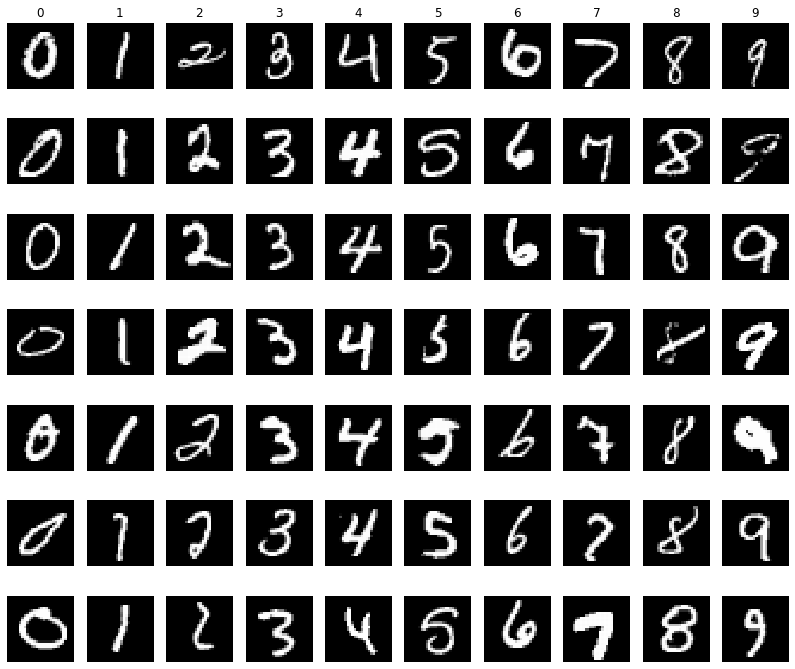

In [ ]:
classes = list(np.arange(10))
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx])
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset_train, shuffle=True, batch_size=1024, num_workers=1)
test_loader = torch.utils.data.DataLoader(dataset_test, shuffle=True, batch_size=1024)

In [ ]:
data = next(iter(train_loader))
mean = data[0].mean()
std = data[0].std()

In [ ]:
mean, std

(tensor(0.1285), tensor(0.3060))

In [ ]:
dataset_train = torchvision.datasets.MNIST(root='/content/drive/MyDrive', download=False, transform=Compose([ToTensor(), Normalize(mean, std)]))
dataset_test = torchvision.datasets.MNIST(root='/content/drive/MyDrive', train=False, download=False, transform=Compose([ToTensor(), Normalize(mean, std)]))

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset_train, shuffle=True, batch_size=1024, num_workers=1)
test_loader = torch.utils.data.DataLoader(dataset_test, shuffle=True, batch_size=1024)

In [ ]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 64, 3)
        self.lin1 = nn.Linear(64 * 12 * 12, 128)
        self.lin2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        output = F.log_softmax(x, dim=1)
        return output

net = Net().to(device)

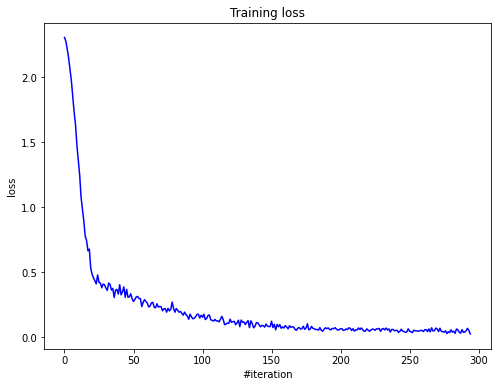

Current loss: 0.023008


In [ ]:
n_epoch = 5
loss_history = []

loss_fun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

for i in range(n_epoch):
  net.train()
  for batch, labels in train_loader:
    batch = batch.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()

    pred = net.forward(batch)

    loss = loss_fun(pred, labels)
    loss.backward()

    optimizer.step()

    loss_history.append(loss)


    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)  


In [ ]:
accs = torch.zeros(10)
losses = torch.zeros(10)
digit_shot = {i: 0 for i in range(10)}
digits_cnt = np.zeros(10)

net.eval()
with torch.no_grad():
  i = 0
  for batch, labels in test_loader:
    batch = batch.cuda()
    labels = labels.cuda()
    preds = net(batch)
    loss = loss_fun(preds, labels)
    label_preds = preds.argmax(dim=1)
    accuracy = (label_preds == labels).sum() / labels.shape[0]
    accs[i] = accuracy
    losses[i] = loss
    label_preds = label_preds.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()
    for j in range(len(labels)):
      if labels[j] == label_preds[j]:
        digit_shot[labels[j]] += 1
      digits_cnt[labels[j]] += 1
    i += 1

print("mean accuracy: ", accs.mean(), 
      "mean loss: ", losses.mean())
for i in range(10):
  print("{} accuracy: {}".format(i, digit_shot[i] / digits_cnt[i]))

mean accuracy:  tensor(0.9855) mean loss:  tensor(0.0472)
0 accuracy: 0.9959183673469387
1 accuracy: 0.9964757709251101
2 accuracy: 0.9893410852713178
3 accuracy: 0.9871287128712871
4 accuracy: 0.9989816700610998
5 accuracy: 0.9854260089686099
6 accuracy: 0.9874739039665971
7 accuracy: 0.9785992217898832
8 accuracy: 0.9774127310061602
9 accuracy: 0.958374628344896


In [ ]:
mini_loader = torch.utils.data.DataLoader(dataset_test, shuffle=True, batch_size=100)
digit_preds = {i: [] for i in range(10)}
digits_cnt = np.zeros(10)

net.eval()
with torch.no_grad():
    batch, labels = next(iter(mini_loader))
    batch = batch.cuda()
    preds = net(batch)
    label_preds = preds.argmax(dim=1)
    label_preds = label_preds.cpu().detach().numpy()
    labels = labels.numpy()
    batch = batch.cpu().detach().numpy()
    for j in range(len(labels)):
      digit_preds[labels[j]].append(label_preds[j])
      digits_cnt[labels[j]] += 1

In [ ]:
min(digits_cnt)

6.0

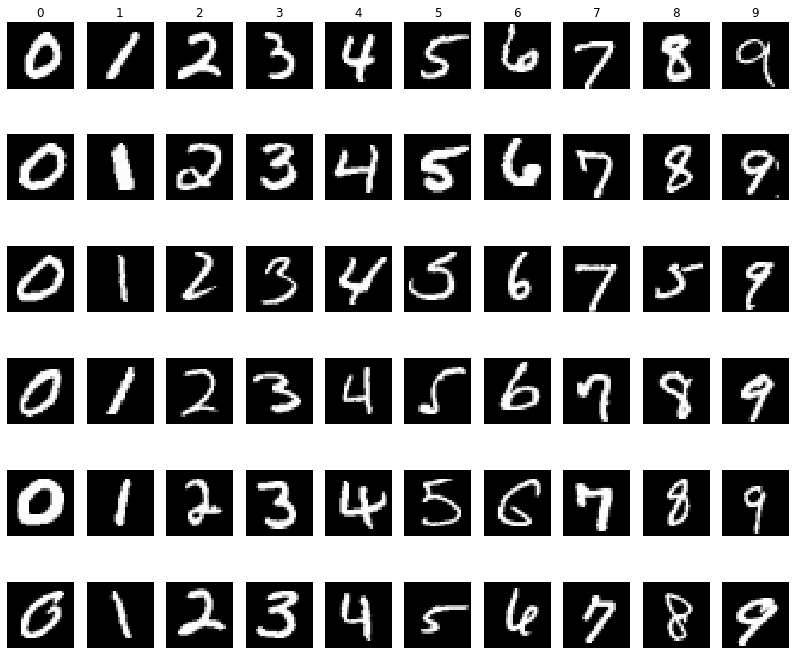

In [ ]:
classes = list(np.arange(10))
num_classes = len(classes)
samples_per_class = int(min(digits_cnt))
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(label_preds.astype(np.int8) == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(batch[idx].reshape((28, 28)))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.bnorm1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 64, 3)
        self.bnorm2 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.3)

        self.lin1 = nn.Linear(64 * 12 * 12, 128)
        self.bnorm3 = nn.BatchNorm1d(128)
        self.lin2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bnorm1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.bnorm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = torch.flatten(x, 1)
        x = self.lin1(x)
        x = self.bnorm3(x)
        x = F.relu(x)
        x = self.lin2(x)
        output = F.log_softmax(x, dim=1)
        return output

net = Net().to(device)

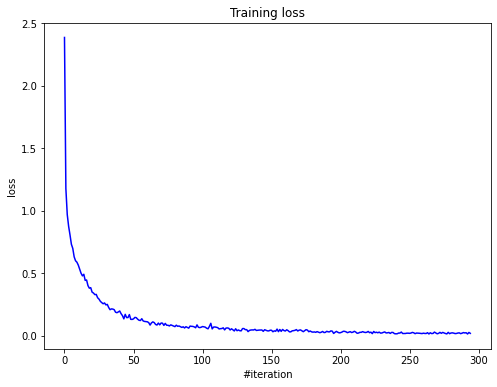

Current loss: 0.019312


In [ ]:
n_epoch = 5

loss_fun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

loss_history = []

for i in range(n_epoch):
  net.train()
  for batch, labels in train_loader:
    batch = batch.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()

    pred = net.forward(batch)

    loss = loss_fun(pred, labels)
    loss_history.append(loss)
    loss.backward()

    optimizer.step()


    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)  


In [ ]:
accs = torch.zeros(10)
losses = torch.zeros(10)
digit_shot = {i: 0 for i in range(10)}
digits_cnt = np.zeros(10)

net.eval()
with torch.no_grad():
  i = 0
  for batch, labels in test_loader:
    batch = batch.cuda()
    labels = labels.cuda()
    preds = net(batch)
    loss = loss_fun(preds, labels)
    label_preds = preds.argmax(dim=1)
    accuracy = (label_preds == labels).sum() / labels.shape[0]
    accs[i] = accuracy
    losses[i] = loss
    label_preds = label_preds.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()
    for j in range(len(labels)):
      if labels[j] == label_preds[j]:
        digit_shot[labels[j]] += 1
      digits_cnt[labels[j]] += 1
    i += 1

print("mean accuracy: ", accs.mean(), 
      "mean loss: ", losses.mean())
for i in range(10):
  print("{} accuracy: {}".format(i, digit_shot[i] / digits_cnt[i]))

mean accuracy:  tensor(0.9907) mean loss:  tensor(0.0313)
0 accuracy: 0.9979591836734694
1 accuracy: 0.9955947136563876
2 accuracy: 0.9903100775193798
3 accuracy: 0.9930693069306931
4 accuracy: 0.9928716904276986
5 accuracy: 0.992152466367713
6 accuracy: 0.9874739039665971
7 accuracy: 0.9863813229571985
8 accuracy: 0.9876796714579056
9 accuracy: 0.9821605550049554


In [ ]:
mini_loader = torch.utils.data.DataLoader(dataset_test, shuffle=True, batch_size=100)
digit_preds = {i: [] for i in range(10)}
digits_cnt = np.zeros(10)

net.eval()
with torch.no_grad():
    batch, labels = next(iter(mini_loader))
    batch = batch.cuda()
    preds = net(batch)
    label_preds = preds.argmax(dim=1)
    label_preds = label_preds.cpu().detach().numpy()
    labels = labels.numpy()
    batch = batch.cpu().detach().numpy()
    for j in range(len(labels)):
      digit_preds[labels[j]].append(label_preds[j])
      digits_cnt[labels[j]] += 1

In [ ]:
min(digits_cnt)

4.0

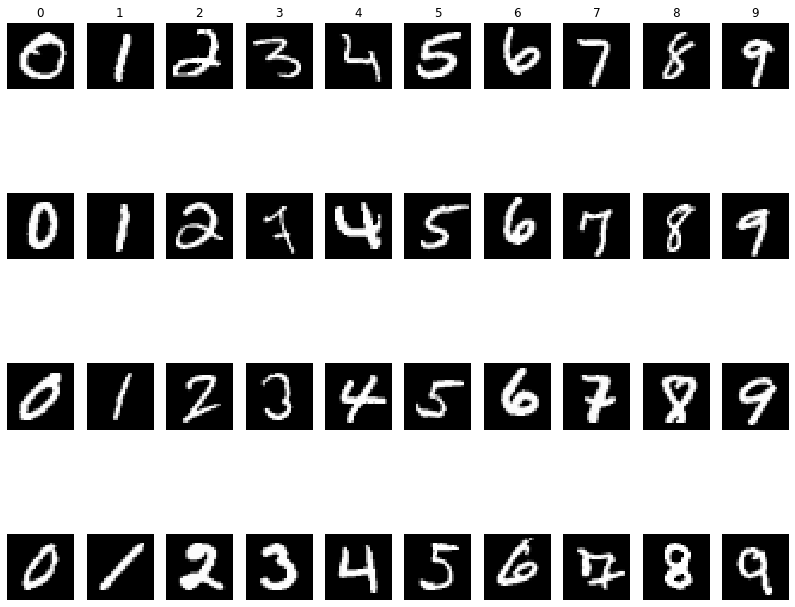

In [ ]:
classes = list(np.arange(10))
num_classes = len(classes)
samples_per_class = int(min(digits_cnt))
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(label_preds.astype(np.int8) == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(batch[idx].reshape((28, 28)))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
mini_loader = torch.utils.data.DataLoader(dataset_test, shuffle=True, batch_size=1)
batch, labels = next(iter(mini_loader))
labels

tensor([5])

In [ ]:
DIGITS_PATH = '/content/drive/MyDrive/digits_bold'

transform = torchvision.transforms.Compose([torchvision.transforms.Grayscale(1), torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Resize((28,28)),
                                            torchvision.transforms.Lambda(lambda x: torchvision.transforms.functional.invert(x))])

In [ ]:
my_digits = torchvision.datasets.ImageFolder(DIGITS_PATH, transform=transform)
mini_loader = torch.utils.data.DataLoader(my_digits, shuffle=True, batch_size=10)

In [ ]:
data = next(iter(mini_loader))
mean = data[0].mean()
std = data[0].std()

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.Grayscale(1), torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Resize((28,28)),
                                            torchvision.transforms.Lambda(lambda x: torchvision.transforms.functional.invert(x)),
                                            Normalize(mean, std)])
my_digits = torchvision.datasets.ImageFolder(DIGITS_PATH, transform=transform)

In [ ]:
mini_loader = torch.utils.data.DataLoader(my_digits, shuffle=True, batch_size=10)
digit_preds = {i: [] for i in range(10)}
digits_cnt = np.zeros(10)

net.eval()
with torch.no_grad():
    batch, labels = next(iter(mini_loader))
    batch = batch.cuda()
    preds = net(batch)
    label_preds = preds.argmax(dim=1)
    label_preds = label_preds.cpu().detach().numpy()
    labels = labels.numpy()
    batch = batch.cpu().detach().numpy()
    for j in range(len(labels)):
      digit_preds[labels[j]].append(label_preds[j])
      digits_cnt[labels[j]] += 1

In [ ]:
label_preds

array([7, 7, 0, 2, 3, 1, 6, 8, 4, 5])

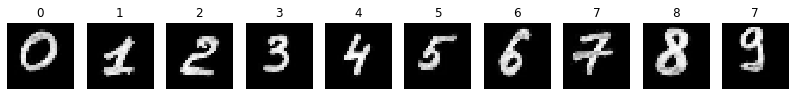

In [ ]:
classes = list(np.arange(10))
num_classes = len(classes)
samples_per_class = 1
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(labels.astype(np.int8) == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(batch[idx].reshape((28, 28)))
        plt.axis('off')
        if i == 0:
            plt.title(label_preds[idx])
plt.show()